In [18]:
import re # regex
import pandas as pd # tables
import matplotlib.pyplot as plt # plots
import seaborn as sns # plots
import numpy as np # operations with arrays and matrices 
import tensorflow as tf
from tqdm import tqdm
from wordcloud import WordCloud
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:992)>
[nltk_data] Error loading wordnet: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:992)>


                                               Input     Sentiment
0  i feel kind of insecure here anyways back to doha          fear
1  i missed the blessing of god s providence the ...         trust
2                The beauty of the horseshoe effect.  anticipation
3  i just remember feeling frantic desperately tr...          fear
4               Awesome! Hope you had a good holiday  anticipation


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


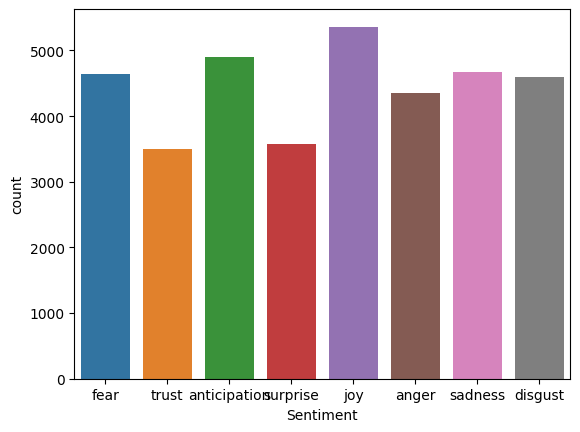

In [2]:
train_df = pd.read_csv('final_train.csv', encoding='utf-8')
test_df  = pd.read_csv('final_test.csv', encoding='utf-8')
val_df  = pd.read_csv('final_validate.csv', encoding='utf-8')

train_df['Input'] = train_df['Input'].replace('love', 'trust')
test_df ['Input'] = test_df ['Input'].replace('love', 'trust')
val_df ['Input'] = val_df ['Input'].replace('love', 'trust')

# train = pd.read_csv('train.txt', header =None, sep =';', names = ['Input','Sentiment'], encoding='utf-8')
# test = pd.read_csv('test.txt', header = None, sep =';', names = ['Input','Sentiment'],encoding='utf-8')
# validation = pd.read_csv('val.txt',header=None,sep=';', names=['Input','Sentiment'], encoding='utf-8')

print(train_df.head())
sns.countplot(train_df, x='Sentiment')
plt.show()

In [3]:
data = {'Train Data': train_df, 'Validation Data': val_df, 'Test Data': test_df}
for temp in data:
    print(temp)
    print(data[temp].isnull().sum())
    print('*'*20)

Train Data
Input        0
Sentiment    0
dtype: int64
********************
Validation Data
Input        0
Sentiment    0
dtype: int64
********************
Test Data
Input        0
Sentiment    0
dtype: int64
********************


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: 

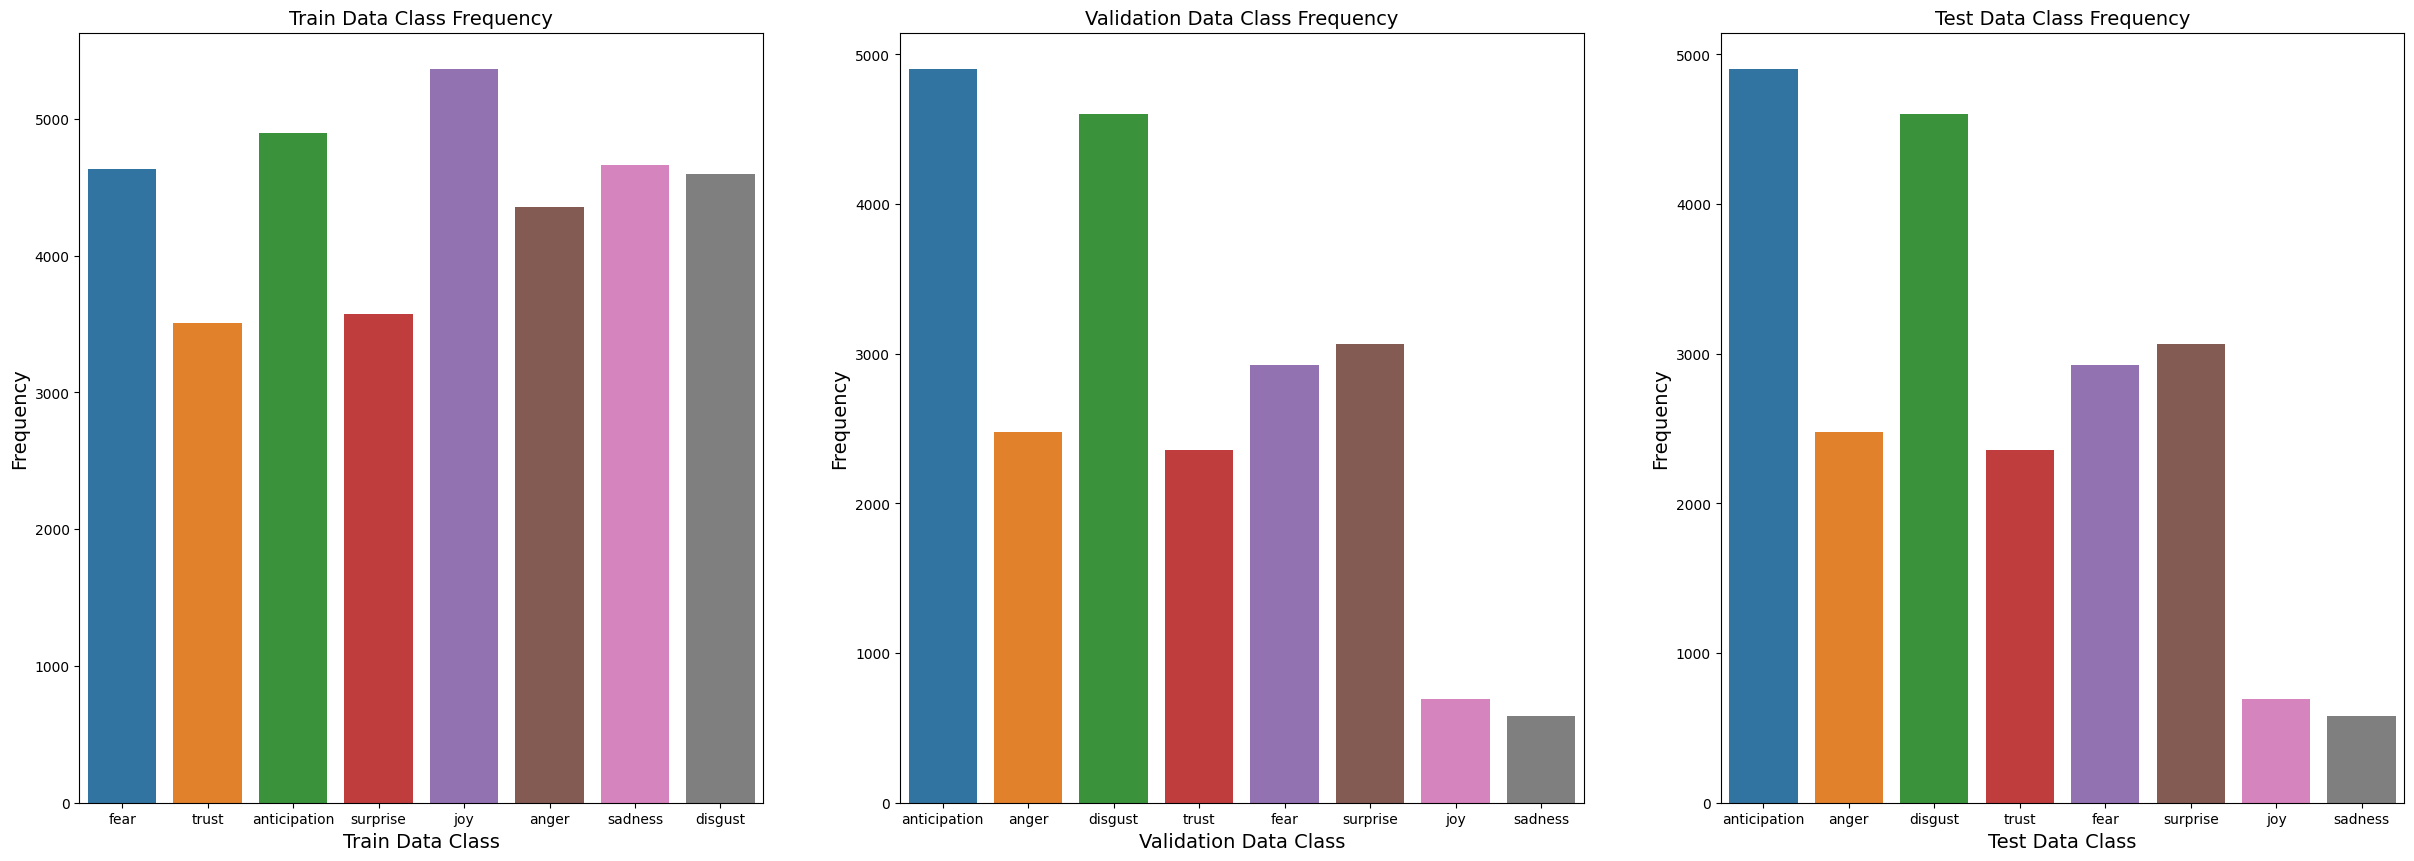

In [4]:
bar, ax = plt.subplots(1,3, figsize=(30, 10))
for index, temp in enumerate(data):
    sns.countplot(ax = ax[index],x = 'Sentiment', data = data[temp])
    ax[index].set_title(temp+' Class Frequency', size=14)
    ax[index].set_ylabel('Frequency', size=14)
    ax[index].set_xlabel(temp+' Class', size=14)

In [5]:
def plot_cloud(wordcloud, temp):
    plt.figure(figsize=(10, 10))
    plt.title(temp+' Word Cloud', size = 16)
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");

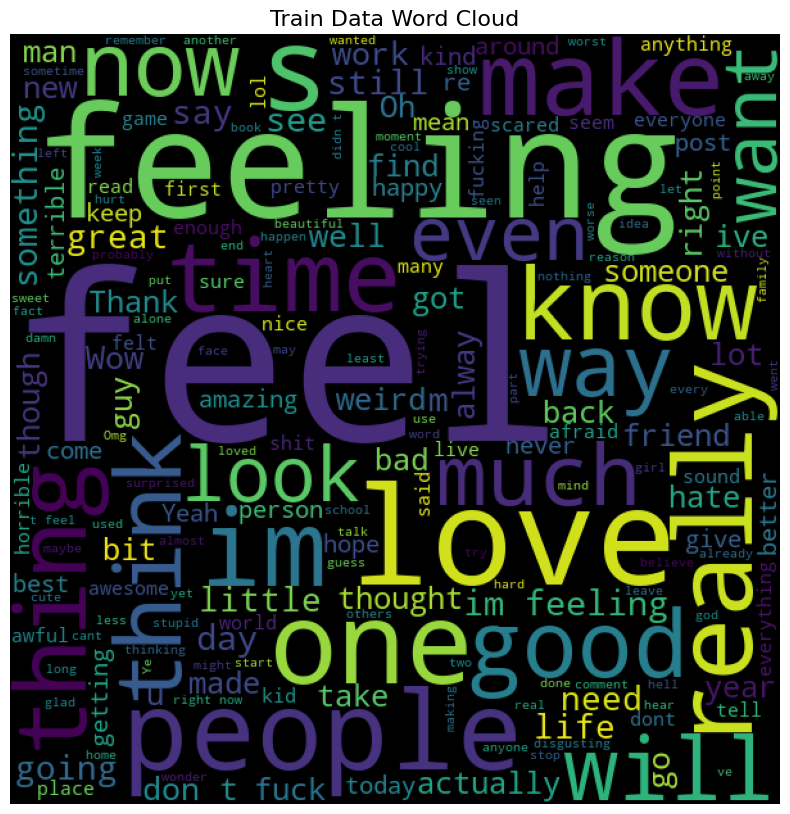

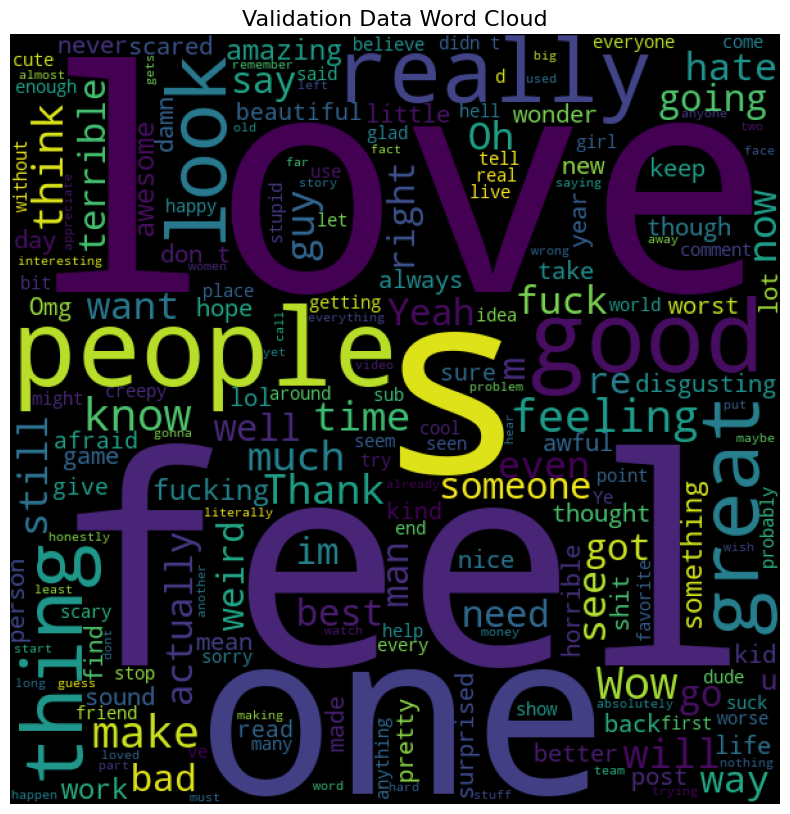

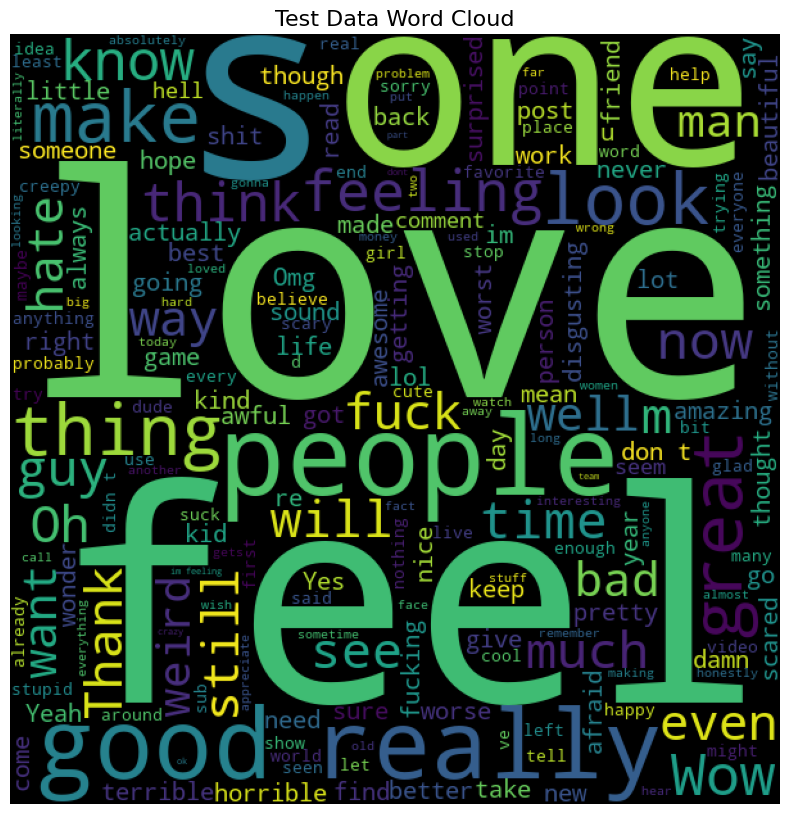

In [6]:
for temp in data:
    temp_text = ' '.join([sentence for sentence in data[temp].Input])
    wordcloud = WordCloud(width = 600, height = 600).generate(temp_text)
    plot_cloud(wordcloud, temp)

In [7]:
le = LabelEncoder()
train_df['Sentiment'] = le.fit_transform(train_df['Sentiment'])
val_df['Sentiment'] = le.transform(val_df['Sentiment'])

In [8]:
class EmotionDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        text = str(self.df.loc[index, 'Input'])
        emotion = self.df.loc[index, 'Sentiment']

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'emotion': torch.tensor(emotion, dtype=torch.long)
        }

In [9]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [10]:
batch_size = 32

# set the maximum sequence length
max_len = 150

# create data loaders for the training and validation sets
train_dataset = EmotionDataset(train_df, tokenizer, max_len)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = EmotionDataset(val_df, tokenizer, max_len)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [11]:
class BertSentimentClassifier(nn.Module):
    def __init__(self, bert_model_name, num_classes):
        super(BertSentimentClassifier, self).__init__()
        
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.dropout1 = nn.Dropout(0.2)
        self.fc1 = nn.Linear(self.bert.config.hidden_size, 256)
        self.dropout2 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(256, num_classes)


    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout1(pooled_output)
        output = self.fc1(pooled_output)
        output = self.dropout2(output)
        logits = self.fc2(output)
        
        return logits

In [12]:
bert_model_name = "bert-base-uncased"
num_classes = train_df["Sentiment"].nunique()
model = BertSentimentClassifier(bert_model_name, num_classes)

In [13]:
criterion = nn.CrossEntropyLoss()

In [20]:
def train(model, data_loader, optimizer, criterion, device):
    # set the model to train mode
    model.train()
    
    # initialize the loss and accuracy 
    total_loss, total_accuracy = 0, 0
    
    # iterate over the data loader
    for data in tqdm(data_loader):
        # move the inputs to the device
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        labels = data['emotion'].to(device)
        
        # zero the gradient
        optimizer.zero_grad()
    
        # get the model's predictions
        outputs = model(input_ids, attention_mask)

        # get the loss
        loss = criterion(outputs, labels)
        total_loss += loss.item()

        # accuracy calculation
        logits = outputs.detach().cpu().numpy()
        label_ids = labels.to('cpu').numpy()

        total_accuracy += flat_accuracy(logits, label_ids)

        # perform backpropagation and optimization
        loss.backward()
        optimizer.step()

    # calculate the average loss
    avg_loss = total_loss / len(data_loader)
    avg_acc = total_accuracy / len(data_loader)


    return avg_loss, avg_acc

In [21]:
def evaluate(model, data_loader, criterion, device):
    # set the model to eval mode
    model.eval()
    
    # initialize the loss and accuracy variables
    total_loss = 0
    total_accuracy = 0
    
    # iterate over the data loader
    for data in tqdm(data_loader):
        # move the inputs to the device
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        labels = data['emotion'].to(device)
        
        # disable gradient computation
        with torch.no_grad():
            # get the model's predictions
            outputs = model(input_ids, attention_mask)

            # get the loss
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            # calculate the number of correct predictions
            logits = outputs.detach().cpu().numpy()
            label_ids = labels.to('cpu').numpy()

            total_accuracy += flat_accuracy(logits, label_ids)
    
    # calculate the average loss and accuracy
    avg_loss = total_loss / len(data_loader)
    accuracy = total_accuracy / len(data_loader)
    
    return avg_loss, accuracy

In [22]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [23]:
# set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# set the learning rate
lr = 2e-5

# set the number of epochs
num_epochs = 10

# set the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# move the model to the device
model.to(device)

# lists to store metrics
train_losses = []
train_accuracies = []

val_losses = []
val_accuracies = []

# iterate over the epochs
for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1} ')
    # train the model
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    
    # evaluate the model on the validation set
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    
    # print the loss and accuracy
    print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')
        
    # Save the loss and accuracy values
    train_accuracies.append(train_acc)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Save the model weights
    torch.save(model.state_dict(), f'weights_epoch{epoch + 1}.pt')

Epoch 1 


  1%|          | 6/1113 [00:39<1:59:09,  6.46s/it]

In [ ]:
import matplotlib.pyplot as plt

def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    
    # Plot the training loss curve
    ax[0].plot(train_losses, label='Training Loss')
    ax[0].plot(val_losses, label='Validation Loss')
    
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Training and Validation Loss')
    ax[0].legend()
    
    # Plot the training accuracy curve
    ax[1].plot(train_accuracies, label='Training Accuracy')
    ax[1].plot(val_accuracies, label='Validation Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Training and Validation Accuracy')
    
    plt.show()

In [ ]:
input_text = test_df.sample(n=1).text.values[0]
input_text

In [ ]:
encoded_input = tokenizer.encode_plus(
    input_text, 
    add_special_tokens=True,
    truncation=True,
    max_length= max_len,
    return_token_type_ids=False,
    padding='max_length',
    return_attention_mask=True,
    return_tensors='pt',
).to(device)

In [ ]:
emotion_id = torch.argmax(model(**encoded_input), dim=1).item()

In [ ]:
le.inverse_transform([emotion_id])

In [ ]:
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)